In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import string
import os
from navec import Navec
from slovnet.model.emb import NavecEmbedding
from retell_utils.metrics import get_cosine_sim, jaccard_text, plot_bar_jac_cos_metric
from tqdm.notebook import tqdm
from pathlib import Path
from retell_utils.corpora_sugar import CorpusSugar
from tg.grammar_ru.corpus import CorpusReader

In [28]:
from tg.common._common import DataBundle

In [33]:
retell_corpus = CorpusReader(Path("./featurized_corpuses/All retell.featurized.retell.corpus.zip"))
text_corpus = CorpusReader(Path("./featurized_corpuses/books.featurized.zip"))
martin_mapping = retell_corpus.read_mapping_data()

In [34]:
corpus_sugar = CorpusSugar(text_corpus, retell_corpus)
books, retell_books, summar_books = corpus_sugar.get_books_retell_info_by_author('Мартин')

In [35]:
model_path = Path("./navec_hudlit_v1_12B_500K_300d_100q.tar")
navec = Navec.load(model_path)
embeder = NavecEmbedding(navec)

/home/mixailkys/anaconda3/envs/grammar_ru/lib/python3.8/site-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402316912/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  torch.from_numpy(navec.pq.indexes),


In [36]:
db = DataBundle.load('./Martin-bundle.zip')
martin_spec_word_vocab = db.words.set_index('word').nf_n.to_dict()

In [37]:
fine_tuned_vec = pd.read_csv(Path("./Martin-nonce-freq-joint.csv"), sep='\t').iloc[:, 1:]
better_fine_tuned_vec = pd.read_csv(Path("./Martin-better.csv"), sep='\t').iloc[:, 1:]

In [8]:
fine_tuned_vec

,0,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,600,601
0,0.078562,-0.149655,-0.150364,0.249070,-0.212301,-0.057017,-0.063265,0.071950,-0.024585,-0.164026,...,0.197237,0.084040,-0.128762,-0.251915,-0.075777,0.037815,-0.072577,0.254591,-0.156577,10.047770
1,0.239270,-0.111247,0.019034,0.103700,-0.234546,-0.142890,-0.005711,0.046616,-0.130710,0.040332,...,-0.127117,0.043515,-0.079331,-0.275815,-0.153601,0.040854,0.021165,0.006768,-0.090977,7.619809
2,0.166898,-0.045892,0.204491,0.021266,-0.031156,0.133396,-0.123712,0.126124,-0.034461,-0.123917,...,-0.238819,0.129897,-0.063659,-0.277777,0.014659,0.002224,0.019845,0.047059,0.048151,6.699155
3,-0.282157,0.257812,0.154728,-0.002214,-0.396217,0.379055,0.322976,-0.140838,0.068028,-0.150257,...,-0.226491,-0.103059,0.032430,-0.012872,0.104019,-0.115509,0.104306,0.085083,0.034918,-0.746034
4,-0.134081,-0.150762,0.382866,0.014230,-0.079229,-0.072625,0.145221,0.107703,0.287233,0.069872,...,-0.196095,0.269739,0.090484,0.227618,-0.014680,-0.106048,-0.328925,-0.250228,0.267152,-7.142938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22719,-0.183731,-0.164664,-0.147866,-0.075879,-0.506226,-0.096745,0.465308,-0.108243,0.159901,0.073891,...,0.007066,-0.395104,-0.229404,-0.169331,-0.149122,-0.439416,0.229929,-0.193889,-0.183202,-2.231250
22720,-0.612528,0.140600,0.080018,0.209475,-0.083971,0.421585,0.083721,-0.119106,0.638967,0.007093,...,-0.293196,-0.106125,0.204108,-0.286618,0.313053,0.055532,0.199639,-0.058503,0.048637,-2.551485
22721,0.004930,-0.089103,0.128378,-0.018897,-0.222218,0.257464,-0.011307,0.392141,0.334541,0.025384,...,0.027572,0.084807,0.281078,-0.013508,0.431241,-0.075631,0.036951,0.056186,-0.014317,-3.662147
22722,-0.082320,-0.049989,0.128470,-0.028104,-0.268497,0.412939,-0.050845,0.151159,0.375527,-0.080062,...,-0.151502,0.168638,0.237744,0.070377,0.431631,-0.022061,-0.084824,0.161286,-0.046993,-3.697859


In [38]:
def get_sentences(chapter):
    chptr = text_corpus.get_bundles([chapter]).single()
    chapter_id = chptr.src
    sentences_id = np.array(chapter_id['sentence_id'].unique())
    sentences = [chapter_id['word'].values[chapter_id['sentence_id'] == sentence_id]
                 for sentence_id in sentences_id]
    return sentences


def get_classic_embeding(token,martin_vec = fine_tuned_vec):
    if token in martin_spec_word_vocab:
        return torch.tensor(martin_vec.iloc[martin_spec_word_vocab[token]][:300])
    else:
        return embeder(torch.tensor(navec.vocab['<unk>']))


def get_split_tokens_embeding_part(token: str,martin_vec = fine_tuned_vec):
    get_martin_emd = lambda tok: torch.tensor(
        martin_vec.iloc[martin_spec_word_vocab[tok]][:300])
    token_splited = token.split('-')
    if len(token_splited) == 2 and len(token_splited[0]) > 2:
        if len(token_splited[1]) > 2:
            if token_splited[0] in martin_spec_word_vocab and token_splited[1] in martin_spec_word_vocab:
                return get_martin_emd(token_splited[0]) + \
                    get_martin_emd(token_splited[1])
        elif token_splited[1] in ["ка", "то"]:
            return get_martin_emd(token_splited[0])

    if token in martin_spec_word_vocab:
        return get_martin_emd(token)
    else:
        return embeder(torch.tensor(navec.vocab['<unk>']))


def get_split_tokens_embeding_full(token: str,martin_vec = fine_tuned_vec):
    get_martin_emd = lambda tok: torch.tensor(martin_vec.iloc[martin_spec_word_vocab[tok]])
    token_splited = token.split('-')
    if len(token_splited) == 2 and len(token_splited[0]) > 2:
        if len(token_splited[1]) > 2:
            if token_splited[0] in martin_spec_word_vocab and token_splited[1] in martin_spec_word_vocab:
                return get_martin_emd(token_splited[0]) + \
                    get_martin_emd(token_splited[1])
        elif token_splited[1] in ["ка", "то"]:
            return get_martin_emd(token_splited[0])

    if token in martin_spec_word_vocab:
        return get_martin_emd(token)
    else:
        return embeder(torch.tensor(navec.vocab['<unk>']))

In [39]:
ban_words = set(string.punctuation + "«—»…")
ban_words.update(["!!", "!?", "?!", "??", "?.."])

In [40]:
def get_extract_retell(embeding_func, retell_detail=5,martin_vec = fine_tuned_vec):
    for book in books[:1]:
        extract_retell = []
        for chapter in tqdm(book.index):
            sentences = get_sentences(chapter)
            vec_sum_sentences = []
            for sentence in sentences:
                tokens = [word.lower() for word in sentence if word not in ban_words]
                sentence_vector_sum = sum([embeding_func(token,martin_vec) for token in tokens])
                vec_sum_sentences.append(sentence_vector_sum / len(tokens) if len(tokens) > 0 else torch.zeros(300))
            importances = []
            cos = torch.nn.CosineSimilarity(dim=0)
            for i in range(len(vec_sum_sentences)):
                importance = 0
                for j in range(i, len(vec_sum_sentences)):
                    importance += cos(vec_sum_sentences[i], vec_sum_sentences[j])
                importances.append(importance)
            sorted_index_array = np.argsort(importances)[::-1]
            top_sentences = [" ".join(sentences[id]) for id in sorted_index_array[:retell_detail]]
            extract_retell.append("\n".join(top_sentences))
        return extract_retell  # TODO Если будет несколько книг, нужно сдвинуть return до первого for-а

In [41]:
def better_get_extract_retell__(embeding_func, retell_detail=5,martin_vec = fine_tuned_vec):
    for book in books[:1]:
        extract_retell = []
        for chapter in tqdm(book.index):
            sentences = get_sentences(chapter)
            vec_sum_sentences_f = []
            vec_sum_sentences_s = []
            for sentence in sentences:
                tokens = [word.lower() for word in sentence if word not in ban_words]
                embeded = [embeding_func(token,martin_vec) for token in tokens]
                sentence_vector_sum_f = sum([vec[:300] if len(vec) > 300 else vec for vec in embeded])
                sentence_vector_sum_s = sum([vec[301:601] if len(vec) > 300 else vec for vec in embeded])
                vec_sum_sentences_f.append(sentence_vector_sum_f / len(tokens) if len(tokens) > 0 else torch.zeros(300))
                vec_sum_sentences_s.append(sentence_vector_sum_s / len(tokens) if len(tokens) > 0 else torch.zeros(300))
            importances = []
            cos = torch.nn.CosineSimilarity(dim=0)
            for i in range(len(vec_sum_sentences_f)):
                importance = 0
                for j in range(len(vec_sum_sentences_f)):
                    if i != j:
                        importance += cos(vec_sum_sentences_f[i], vec_sum_sentences_s[j])
                importances.append(importance)
            sorted_index_array = np.argsort(importances)[::-1]
            top_sentences = [" ".join(sentences[id]) for id in sorted_index_array[:retell_detail]]
            extract_retell.append("\n".join(top_sentences))
        return extract_retell  # TODO Если будет несколько книг, нужно сдвинуть return до первого for-а

In [42]:
retell_detail = 5

In [4]:
embed_dict_names = ['base','better']
importance_calc_names = ['simular_vec','base_contex_vec']
embeder_names = ['2dict','split_part','split_full']

In [35]:
extract_result = {}
i = 0
for embed_dict, embed_dict_name in zip([fine_tuned_vec,better_fine_tuned_vec],['base','better']):
    extract_result[embed_dict_name] = {}
    for importance_calc, importance_calc_name in zip([get_extract_retell,better_get_extract_retell__],['simular_vec','base_contex_vec']):
        extract_result[embed_dict_name][importance_calc_name] = {}
        for embed,embed_name in zip([get_classic_embeding,get_split_tokens_embeding_part,get_split_tokens_embeding_full],['2dict','split_part','split_full']):
            if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                continue
            extract_retell = importance_calc(embed,retell_detail,embed_dict)
            extract_result[embed_dict_name][importance_calc_name][embed_name] = extract_retell
            i+=1
            print(f"Пересказов выполнено: {i}")

  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 1


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 2


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 3


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 4


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 5


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 6


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 7


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 8


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 9


  0%|          | 0/82 [00:00<?, ?it/s]

Пересказов выполнено: 10


In [2]:
separator ="\n<separator>\n"
dir_name = "retell_fine_tuned"

In [82]:
if not os.path.isdir(dir_name):
    os.mkdir("retell_fine_tuned")
os.chdir("retell_fine_tuned")
for embed_dict_name in embed_dict_names:
    for importance_calc_name in importance_calc_names:
        for embed_name in embeder_names:
            if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                continue
            file_name = embed_dict_name+"_"+importance_calc_name+"_"+embed_name
            retell_text = extract_result[embed_dict_name][importance_calc_name][embed_name]
            with open(f'{file_name}.txt', 'w') as f:
                for chapter in retell_text:
                    f.write(f"{chapter}{separator}")
os.chdir("../")

In [83]:
def get_saved_retell():
    extract_result = {}
    for embed_dict_name in embed_dict_names:
        extract_result[embed_dict_name] = {}
        for importance_calc_name in importance_calc_names:
            extract_result[embed_dict_name][importance_calc_name] = {}
            for embed_name in embeder_names:
                if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                    continue
                file_name = embed_dict_name+"_"+importance_calc_name+"_"+embed_name
                with open(f'{file_name}.txt', 'r') as f:
                    lines = f.readlines()
                sep = separator[1:]
                book = []
                chapter = ''
                for line in lines:
                    if line != sep:
                        chapter += line
                    else:
                        book.append(chapter)
                        chapter = ''
                extract_result[embed_dict_name][importance_calc_name][embed_name] = book
    return extract_result
os.chdir(dir_name)
extract_result = get_saved_retell()
os.chdir("../")

In [84]:
true_retell = []
for book in retell_books[:1]:
    for chapter in book.index:
        chptr = retell_corpus.get_bundles([chapter]).single().src
        sentences_id = np.array(chptr['sentence_id'].unique())
        sentences = [chptr['word'][chptr['sentence_id'] == sentence_id] for sentence_id in sentences_id]
        true_retell.append("\n".join(" ".join(sentence.values) for sentence in sentences[:retell_detail]))

In [85]:
dict_jaccard_sim, dict_cos_sim = {}, {}
names = []
for embed_dict_name in embed_dict_names:
    dict_jaccard_sim[embed_dict_name] = {}
    dict_cos_sim[embed_dict_name] = {}
    for importance_calc_name in importance_calc_names:
        dict_jaccard_sim[embed_dict_name][importance_calc_name] = {}
        dict_cos_sim[embed_dict_name][importance_calc_name] = {}
        for embed_name in embeder_names:
            if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                continue
            retell = extract_result[embed_dict_name][importance_calc_name][embed_name]
            jaccard_sim = np.array([jaccard_text(retell[i], true_retell[i]) for i in range(len(true_retell))])
            cos_sim = np.array([get_cosine_sim(retell[i], true_retell[i]) for i in range(len(true_retell))])
            dict_jaccard_sim[embed_dict_name][importance_calc_name][embed_name] = jaccard_sim
            dict_cos_sim[embed_dict_name][importance_calc_name][embed_name] = cos_sim

In [86]:
def bar_jac_cos_metric(embed_dict_name, metric,metric_name):
    v, h = 3, 2
    fig, axis = plt.subplots(v, h,figsize=(8,8))
    fig.suptitle(f'{metric_name} - {embed_dict_name}')
    for i, embed_name  in enumerate(embeder_names):
        for j, importance_calc_name in enumerate(importance_calc_names):
            if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                continue
            metr_value = metric[embed_dict_name][importance_calc_name][embed_name]
            axis[i,j].bar(range(len(metr_value)), metr_value)
            axis[i,j].set_title(importance_calc_name + " " + embed_name)
    plt.subplots_adjust(left=0, right=1, wspace=0.2, hspace=0.8)


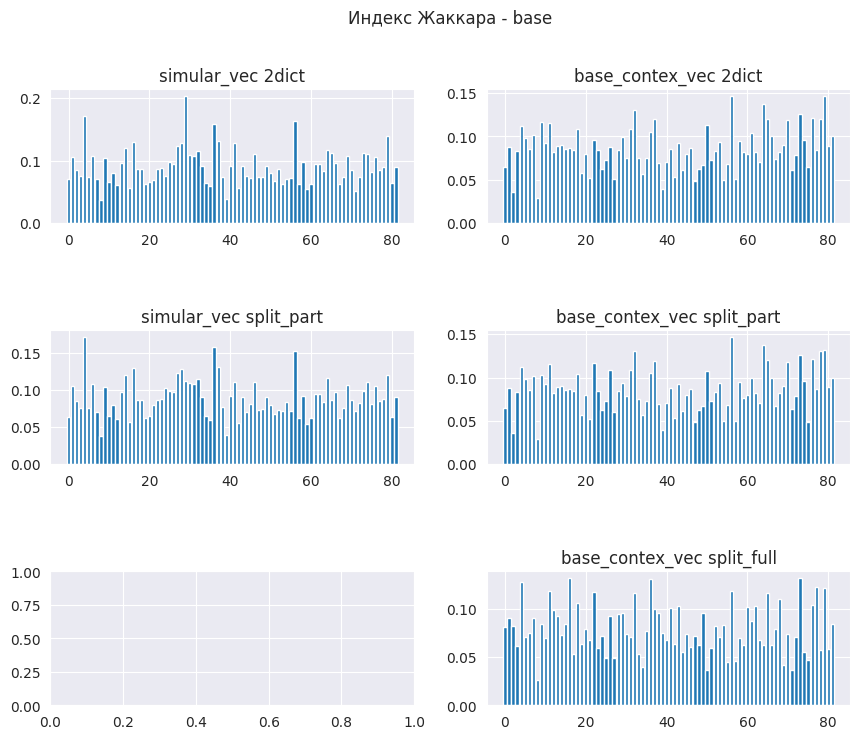

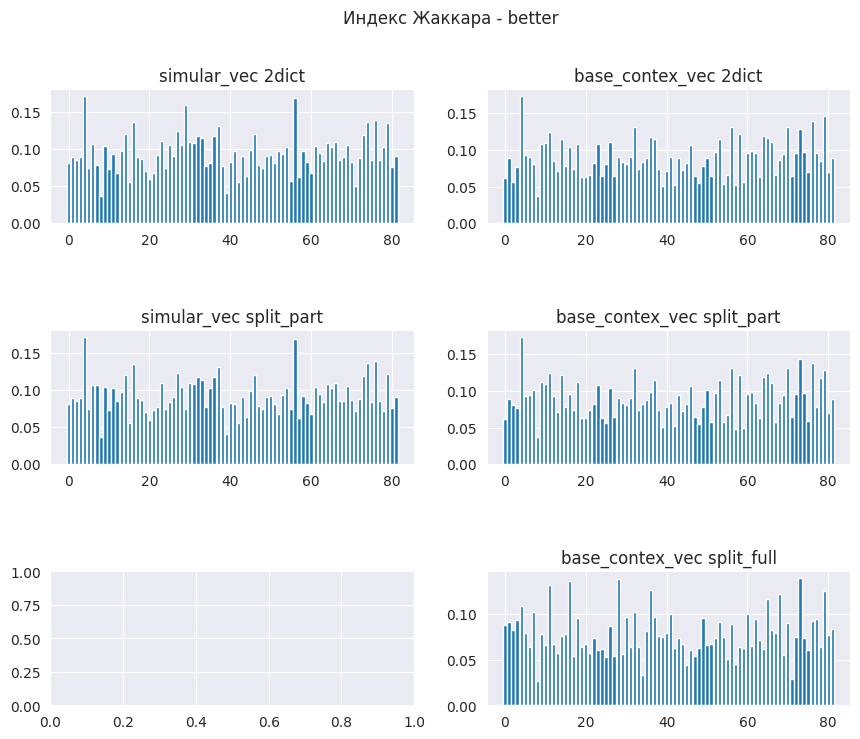

In [87]:
bar_jac_cos_metric('base', dict_jaccard_sim, "Индекс Жаккара")
bar_jac_cos_metric('better', dict_jaccard_sim, "Индекс Жаккара")

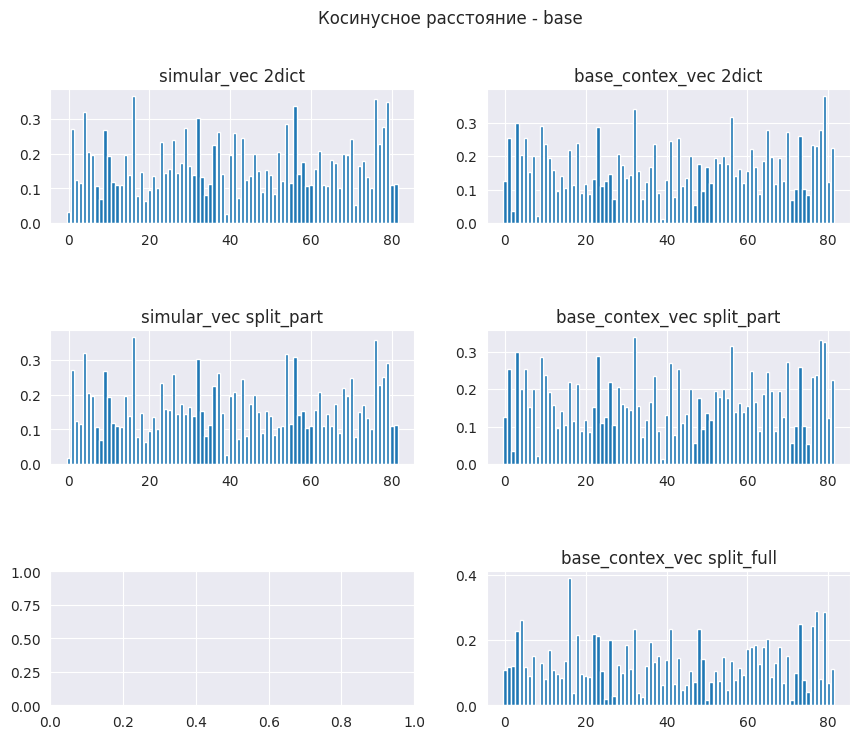

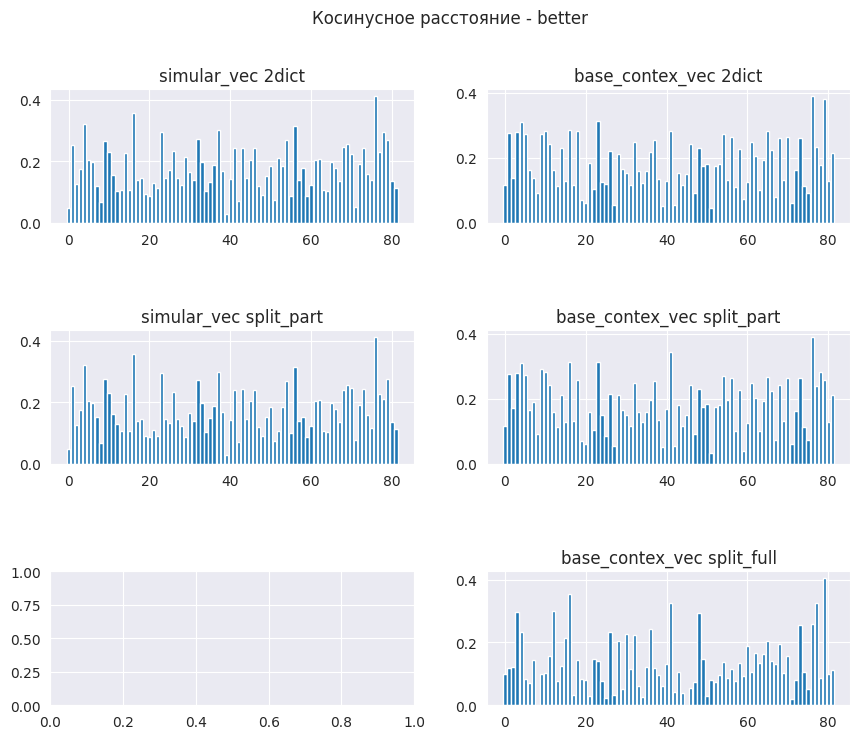

In [88]:
bar_jac_cos_metric('base', dict_cos_sim, "Косинусное расстояние")
bar_jac_cos_metric('better', dict_cos_sim, "Косинусное расстояние")

In [89]:
jacc_med, cos_med, name_comb = [], [], []
jacc_maxis, cos_maxis = [], []
best_jacc_text, best_cos_text,best_index_jacc,best_index_cos = '','',-1,-1
j_maxis, c_maxis = -1, -1
for embed_dict_name in embed_dict_names:
    for importance_calc_name in importance_calc_names:
        for embed_name in embeder_names:
            if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                    continue
            name_comb.append(embed_dict_name + " " + importance_calc_name + " " + embed_name)
            jac_val = dict_jaccard_sim[embed_dict_name][importance_calc_name][embed_name]
            cos_val = dict_cos_sim[embed_dict_name][importance_calc_name][embed_name]
            jacc_mean, jac_max,ii = np.median(jac_val), np.max(jac_val),np.argmax(jac_val)
            cos_mean, cos_max,jj =  np.median(cos_val), np.max(cos_val),np.argmax(cos_val)
            if jac_max >= j_maxis:
                j_maxis = jac_max
                best_index_jacc = ii
                best_jacc_text = extract_result[embed_dict_name][importance_calc_name][embed_name][best_index_jacc]

            if cos_max >= c_maxis:
                c_maxis = cos_max
                best_index_cos = jj
                best_cos_text = extract_result[embed_dict_name][importance_calc_name][embed_name][best_index_cos]
            jacc_med.append(jacc_mean)
            jacc_maxis.append(jac_max)
            cos_med.append(cos_mean)
            cos_maxis.append(cos_max)

<BarContainer object of 10 artists>

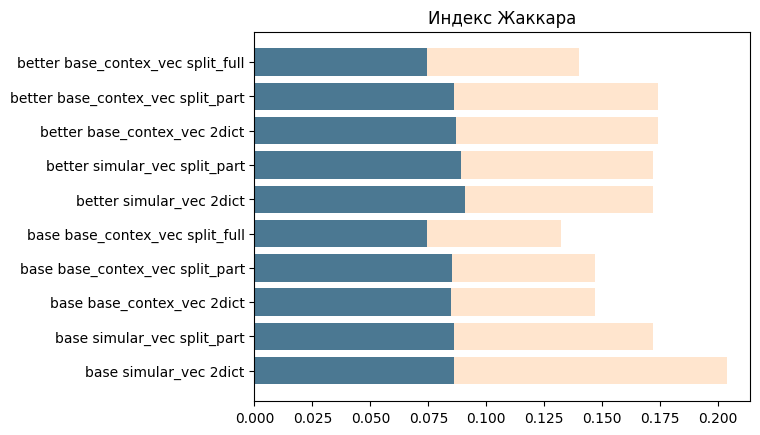

In [109]:
plt.title("Индекс Жаккара")
plt.barh(name_comb, jacc_med,label='mediana')
plt.barh(name_comb, jacc_maxis, label='max', alpha=0.2)

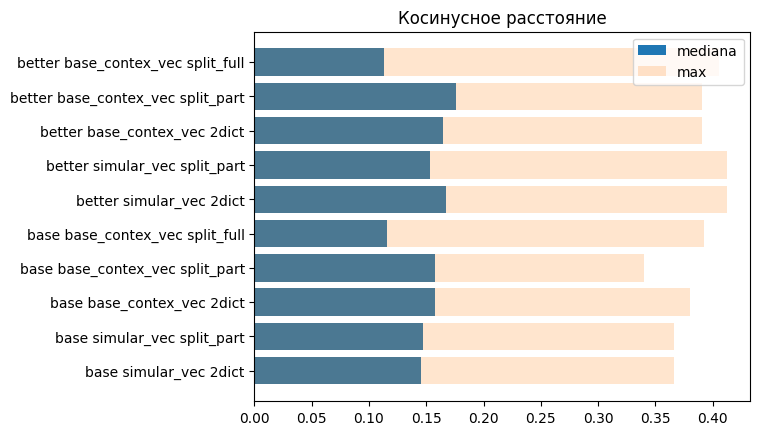

In [110]:
plt.title("Косинусное расстояние")
plt.barh(name_comb, cos_med,label='mediana')
plt.barh(name_comb, cos_maxis, label='max',alpha=0.2)
plt.legend()

In [121]:
print("Лучший пересказ по Индексу Жаккара")
display(best_jacc_text)
print()
true_retell[best_index_jacc]

Лучший пересказ по Индексу Жаккара


'— Как у вас с едой ? — спросил его Том .\nЯ бы сказал , что его растерзанный труп очень бы даже устроил — как и меня .\n— Люди Безумного Короля охотились за Робертом , стараясь схватить его до того , как он соединится с вашим отцом , — рассказывал он , когда они въезжали в ворота .\nПо виду города Арья рассудила , что здесь и в последнее время не обошлось без битв .\nНо Роберта он найти не успел , потому что лорд Эддард и ваш дед подошли к городу и взяли приступом его стены .'

'Арья , Джендри и разбойники из Братства Без Знамен добрались до Каменной Септы .\nХарвин рассказал Арье , что одно из главных сражений восстания Роберта Баратеона - Колокольная битва случилась в Каменной Септе .\nДесница лорд Коннингтон пришел в город с большим войском и стал обыскивать дом за домом .\nВ это время Эддард Старк и Хостер Талли подошли к городу и взяли приступом его стены .\nБорьба бушевала по всему городу .'

In [124]:
print("Лучший пересказ по косинусному расстоянию")
display(best_cos_text)
print()
true_retell[best_index_cos]

Лучший пересказ по косинусному расстоянию


'— Что нужно от меня его величеству ? — спросил Джон , когда они вошли в клеть .\n— Не « он » , — отметил Джон про себя — « мы » .\n— Он и должен быть тяжелым , чтобы остановить меч .\nНастоящая королева — она , а не та , которую Станнис оставил в Восточном Дозоре .\nЗначит , правда то , что все говорят .'

'Джон Сноу во дворе тренирует новобранцев Ночного Дозора .\nЕго тренировку прерывает Мелисандра , и сообщает , что король Станнис ждёт его на Стене .\nНаверху Джон пытается объяснить Станнису , что он не предатель , и король верит ему : Джон похож на своего отца Эддарда , а тот был человеком чести .\nВ то же время Джон говорит , что у одичалых тоже есть своё понятие чести , правда не у всех .\nСтаннис сообщает , что он приехал на Стену , потому что королевство нуждается в защите от действительно настоящего врага - Бога Ночи и Ужаса .'

In [140]:
from tg.common.analysis import Bootstrap, Aggregators, grbar_plot
df_s = []
for embed_dict_name in embed_dict_names:
    for importance_calc_name in importance_calc_names:
        for embed_name in embeder_names:
            if embed_name == 'split_full' and importance_calc_name != 'base_contex_vec':
                continue
            j, c = dict_jaccard_sim[embed_dict_name][importance_calc_name][embed_name], \
            dict_cos_sim[embed_dict_name][importance_calc_name][embed_name]
            #df = pd.DataFrame(data=zip(j,c), columns=['jaccard_sim','cos_sim'])
            metrics_names = ["jaccard_sim" for _ in range(len(j))]+["cos_sim" for _ in range(len(c))]
            df = pd.DataFrame(data=zip(np.concatenate([j,c]),metrics_names), columns=['metric_values','metric_names'])
            df_s.append(df)
# for i,name in enumerate(name_comb):
#     df_s[i] = (df_s[i],name)

In [137]:
df_s[0]

,values,metric_names
0,0.070707,jaccard_sim
1,0.105634,jaccard_sim
2,0.084906,jaccard_sim
3,0.075342,jaccard_sim
4,0.171717,jaccard_sim
...,...,...
159,0.228722,cos_sim
160,0.276211,cos_sim
161,0.347386,cos_sim
162,0.109675,cos_sim


In [ ]:
def compute(df):
    return df.groupby('metric_names').metric_values.mean().to_frame().transpose()

rdf_s = [Bootstrap(df = df, method = compute).run(N=1000) for df in df_s]

In [143]:
normal_confints = [rdf[['jaccard_sim','cos_sim']].feed(Aggregators.normal_confint()) for rdf in rdf_s]

In [142]:
rdf_s[0]

,cos_sim,jaccard_sim,iteration,n
0,0.153925,0.091194,0,0
1,0.165909,0.093669,1,1
2,0.179711,0.091448,2,2
3,0.167590,0.093286,3,3
4,0.162765,0.087086,4,4
...,...,...,...,...
995,0.164089,0.085410,995,995
996,0.165043,0.092062,996,996
997,0.152119,0.093793,997,997
998,0.167153,0.090215,998,998


In [144]:
normal_confints[0]

,jaccard_sim_lower,jaccard_sim_upper,jaccard_sim_value,jaccard_sim_error,cos_sim_lower,cos_sim_upper,cos_sim_value,cos_sim_error
0,0.083832,0.096531,0.090181,0.006349,0.151087,0.183159,0.167123,0.016036


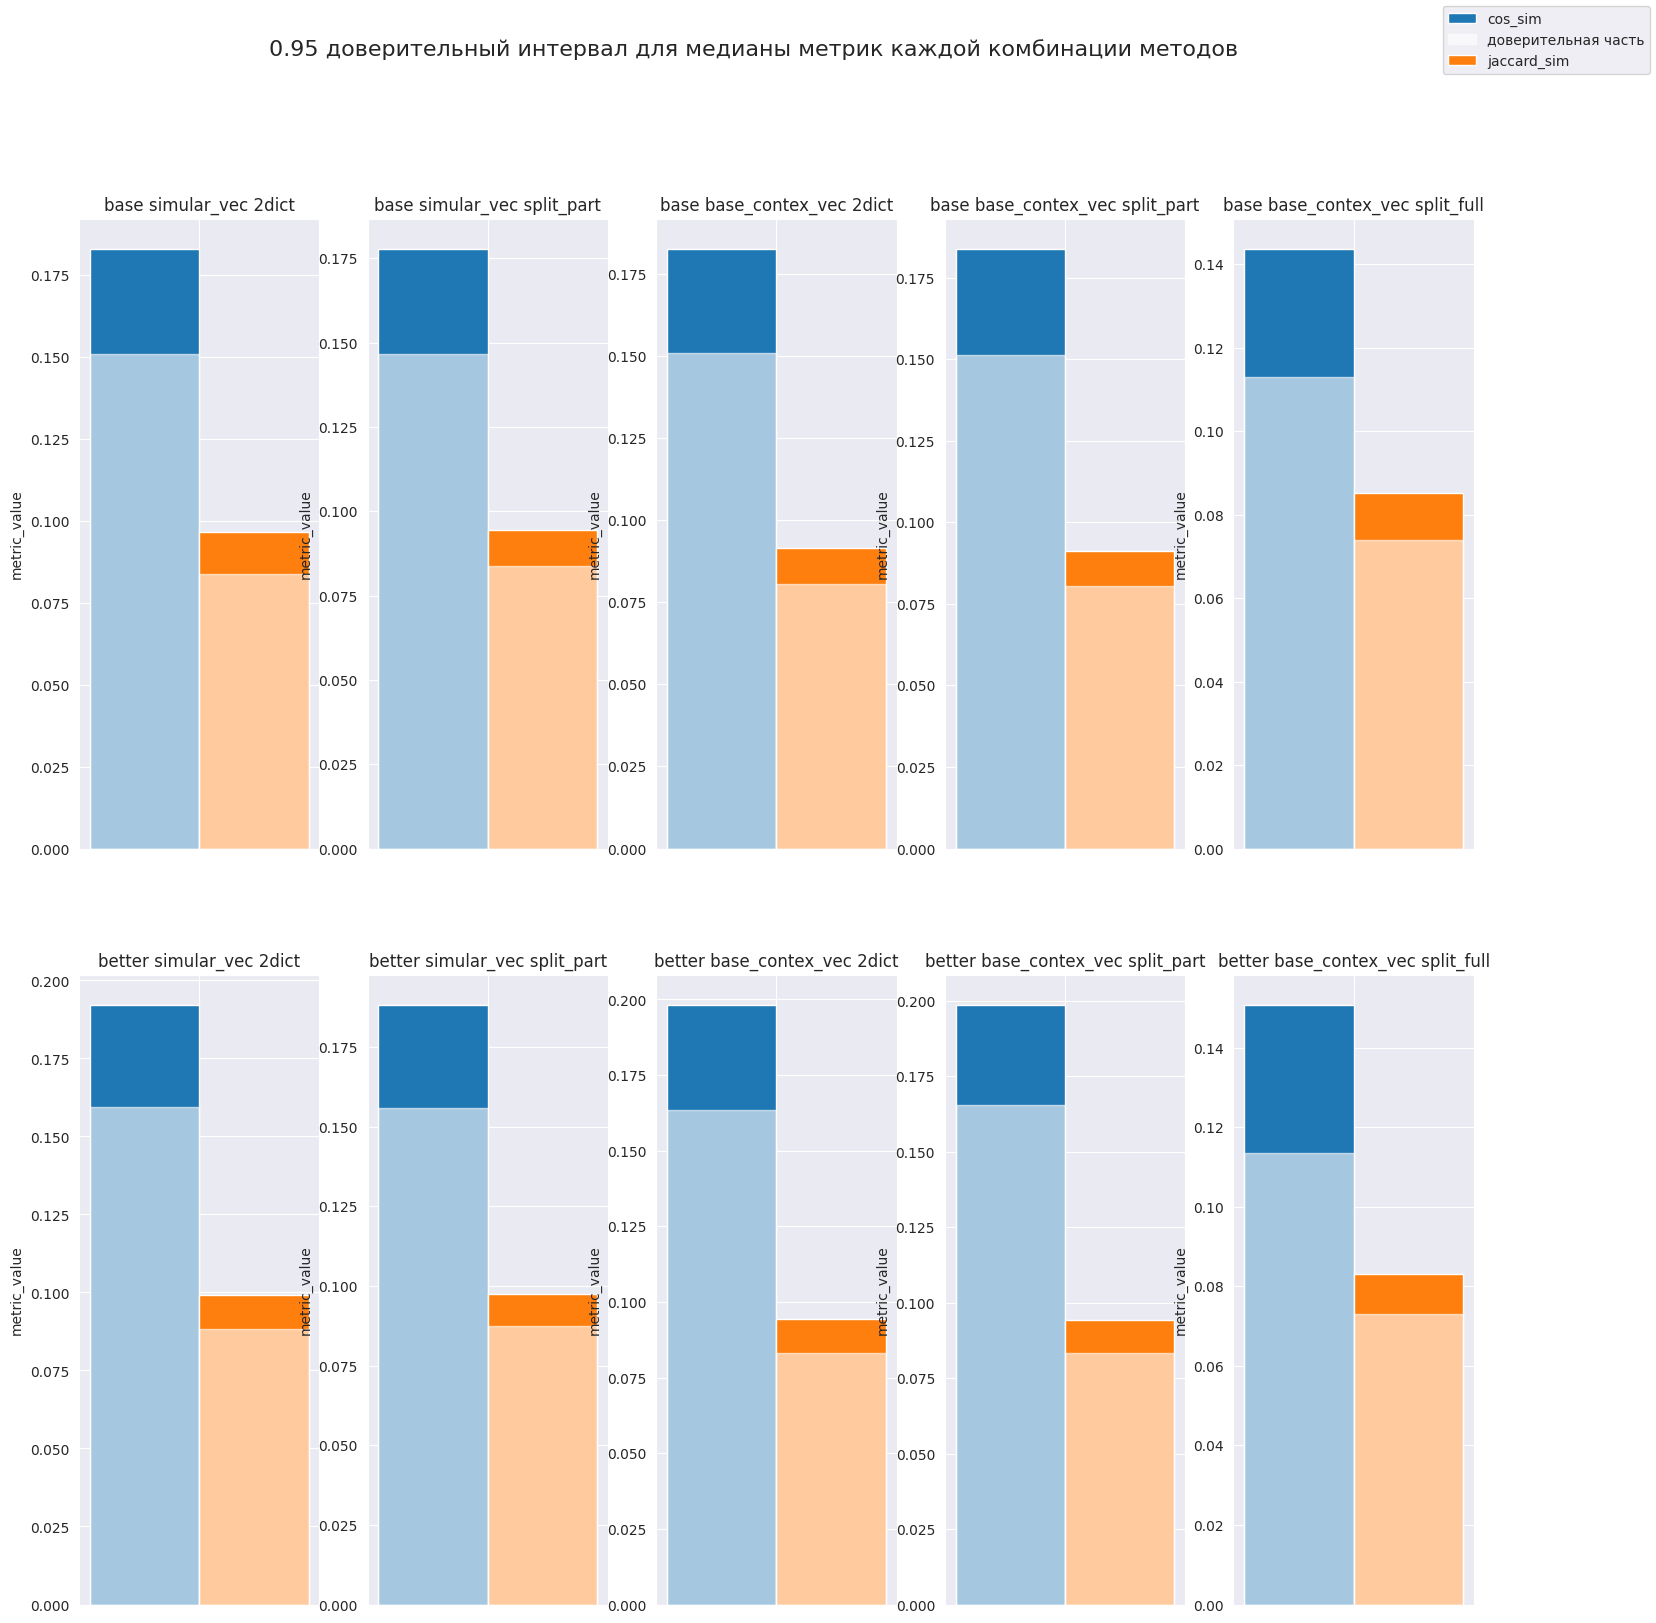

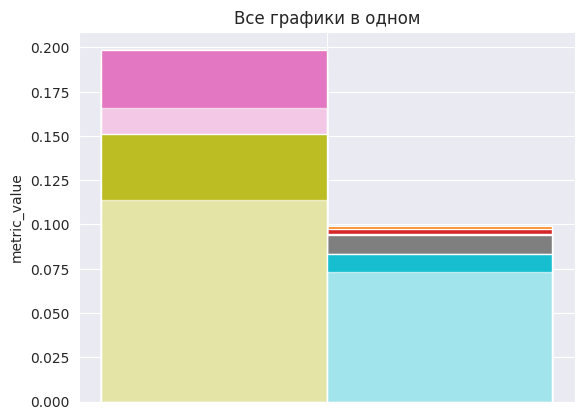

In [223]:
fig, axis = plt.subplots(2,5, figsize=(18, 18))
_,all_in = plt.subplots(1,1)
for i, (rdf,name_) in enumerate(zip(rdf_s,name_comb)):
    rdf_i = rdf[['jaccard_sim','cos_sim']].unstack().to_frame().reset_index()
    rdf_i.columns=['metric_names','iteration','metric']
    t = grbar_plot(
        rdf_i.groupby('metric_names').metric.feed(Aggregators.normal_confint()).reset_index(),
        value_column='metric_value',
        error_column='metric_error',
        color_column='metric_names',
        ax=all_in
    )
    t = grbar_plot(
        rdf_i.groupby('metric_names').metric.feed(Aggregators.normal_confint()).reset_index(),
        value_column='metric_value',
        error_column='metric_error',
        color_column='metric_names',
        ax=axis[i//5,i%5]
    )
    t.set_title(name_)

all_in.set_title("Все графики в одном")
fig.suptitle("0.95 доверительный интервал для медианы метрик каждой комбинации методов",fontsize=16)
fig.legend(["cos_sim","доверительная часть","jaccard_sim"], loc='upper right')
plt.subplots_adjust(wspace=0.4, hspace=0.2)